# Ensemble classifier

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import os

import cv2
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.utils.np_utils import to_categorical


Mounting the Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing the dataset to local environment

In [5]:
!apt-get install p7zip-full
!7za x '/content/drive/MyDrive/Datasetzip'

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 folder, 1 file, 241675852 bytes (231 MiB)

Extracting archive: /content/drive/MyDrive/Datasetzip/Datastcn.zip
--
Path = /content/drive/MyDrive/Datasetzip/Datastcn.zip
Type = zip
Physical Size = 241675852

  0%    
Would you like to replace the existing file:
  Path:     

Creating a dataframe

In [6]:
data_train = []
type_of_disease =['COVID', 'non-COVID']
data_directory = '/content/Datastcn/datasetcn'
train_directory = os.path.join(data_directory)

for id, td in enumerate(type_of_disease):
    for file in os.listdir(os.path.join(train_directory, td)):
        data_train.append(['{}/{}'.format(td, file), id, td])
        
train = pd.DataFrame(data_train, columns=['Image', 'Class ID','Type of Disease'])
train.head()

,Image,Class ID,Type of Disease
0,COVID/Covid (530).png,0,COVID
1,COVID/Covid (242).png,0,COVID
2,COVID/Covid (930).png,0,COVID
3,COVID/Covid (181).png,0,COVID
4,COVID/Covid (138).png,0,COVID


In [7]:
SEED = 42
train = train.sample(frac=1, random_state=SEED)
train.index = np.arange(len(train))
train.head()

,Image,Class ID,Type of Disease
0,COVID/Covid (327).png,0,COVID
1,COVID/Covid (813).png,0,COVID
2,non-COVID/Non-Covid (698).png,1,non-COVID
3,non-COVID/Non-Covid (653).png,1,non-COVID
4,COVID/Covid (329).png,0,COVID


In [8]:
SIZE_OF_IMAGE_D = 64
def read_image(imagepath):
    return cv2.imread(os.path.join(data_directory, imagepath))

def resize_image(image, image_Size):
    return cv2.resize(image.copy(), image_Size, interpolation=cv2.INTER_AREA)

In [9]:
x_train_D = np.zeros((train.shape[0], SIZE_OF_IMAGE_D, SIZE_OF_IMAGE_D, 3))

for i, file in tqdm(enumerate(train['Image'].values)):
    image = read_image(file)
    
    if image is not None:
        x_train_D[i] = resize_image(image,(SIZE_OF_IMAGE_D, SIZE_OF_IMAGE_D))
        
X_Train_D = x_train_D / 255

print('Train shape: {}'.format(X_Train_D.shape))

2481it [00:07, 329.01it/s]

Train shape: (2481, 64, 64, 3)


In [10]:
y_train_D = train['Class ID'].values
y_train_D = to_categorical(y_train_D, num_classes=2)

In [11]:
BATCH_SIZE = 64

X_train_D, X_test_D, Y_train_D, Y_test_D = train_test_split(X_Train_D,y_train_D, test_size=0.2, random_state=SEED)

In [12]:
densenet =  keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/densenet2105_best.h5')

In [ ]:
final_loss, final_acc = model.evaluate(X_test, Y_test)
print("*************************")
print('Loss: {}, Accuracy:{}'.format(final_loss, final_acc))

16/16 [==============================] - 1s 50ms/step - loss: 0.4469 - accuracy: 0.8712
*************************
Loss: 0.44686806201934814, Accuracy:0.8712273836135864


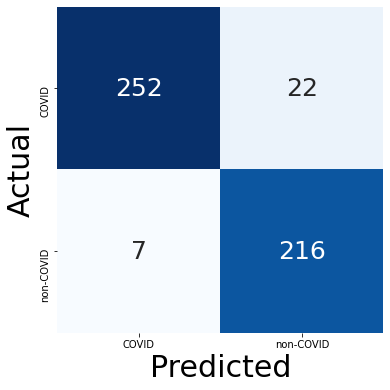

In [13]:
Y_predict_densenet = densenet.predict(X_test_D)
Y_predict_densenet = np.argmax(Y_predict_densenet, axis= 1)
Y_true = np.argmax(Y_test_D, axis=1)


# convert array into dataframe
DF = pd.DataFrame(Y_predict_densenet,columns=['DenseNet121 Prediction'])

# save the dataframe as a csv file
DF.to_csv("densenet.csv",index=False)


cm_densenet = confusion_matrix(Y_true, Y_predict_densenet)
plt.figure(figsize=(6,6))
ax= sns.heatmap(cm_densenet, cmap=plt.cm.Blues, annot=True,fmt='d',annot_kws={"size": 25},cbar=False, square=True, xticklabels=type_of_disease,yticklabels=type_of_disease)
ax.set_ylabel('Actual', fontsize=30)
ax.set_xlabel('Predicted', fontsize=30)
plt.savefig('Confusion matrix_densenet_df.svg', format='svg', dpi=1200)

In [14]:
Y_predict_densenet = densenet.predict(X_train_D)
Y_predict_densenet = np.argmax(Y_predict_densenet, axis= 1)
Y_true = np.argmax(Y_train_D, axis=1)


# convert array into dataframe
DF = pd.DataFrame(Y_predict_densenet,columns=['DenseNet121 Prediction'])

# save the dataframe as a csv file
DF.to_csv("densenet training data.csv",index=False)


In [17]:
metrics_densenet = confusion_metrics(cm_densenet)
print(metrics_densenet)

True Positives: 216
True Negatives: 252
False Positives: 22
False Negatives: 7
--------------------------------------------------
Accuracy: 0.94
Mis-Classification: 0.06
Sensitivity: 0.97
Specificity: 0.92
Precision: 0.92
f1 Score: 0.94
None


In [18]:
mobilenet =  keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/mobilenet1505.h5')

In [19]:
SIZE_OF_IMAGE_M = 150
def read_image(imagepath):
    return cv2.imread(os.path.join(data_directory, imagepath))

def resize_image(image, image_Size):
    return cv2.resize(image.copy(), image_Size, interpolation=cv2.INTER_AREA)

In [20]:
x_train_M = np.zeros((train.shape[0], SIZE_OF_IMAGE_M, SIZE_OF_IMAGE_M, 3))

for i, file in tqdm(enumerate(train['Image'].values)):
    image = read_image(file)
    
    if image is not None:
        x_train_M[i] = resize_image(image,(SIZE_OF_IMAGE_M, SIZE_OF_IMAGE_M))
        
X_Train_M = x_train_M / 255

print('Train shape: {}'.format(X_Train_M.shape))

2481it [00:08, 285.17it/s]


Train shape: (2481, 150, 150, 3)


In [21]:
y_train_M = train['Class ID'].values
y_train_M = to_categorical(y_train_M, num_classes=2)

In [22]:
BATCH_SIZE = 64

X_train_M, X_test_M, Y_train_M, Y_test_M = train_test_split(X_Train_M,y_train_M, test_size=0.2, random_state=SEED)

In [23]:
Y_predict_mobilenet = mobilenet.predict(X_train_M)
Y_predict_mobilenet = np.argmax(Y_predict_mobilenet, axis= 1)
Y_true = np.argmax(Y_train_M, axis=1)


# convert array into dataframe
DF = pd.DataFrame(Y_predict_mobilenet,columns=['MobileNet Prediction'])

# save the dataframe as a csv file
DF.to_csv("mobilenet training data.csv",index=False)

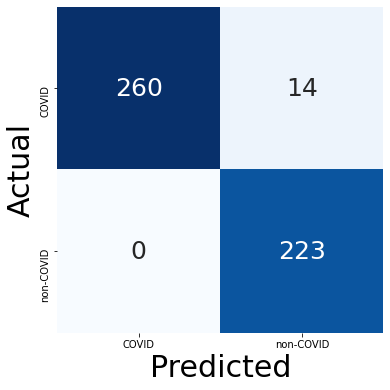

In [28]:
Y_predict_mobilenet = mobilenet.predict(X_test_M)
Y_predict_mobilenet = np.argmax(Y_predict_mobilenet, axis= 1)
Y_true = np.argmax(Y_test_M, axis=1)

cm_mobilenet = confusion_matrix(Y_true, Y_predict_mobilenet)
plt.figure(figsize=(6,6))

ax= sns.heatmap(cm_mobilenet, cmap=plt.cm.Blues, annot=True,fmt='d',annot_kws={"size": 25},cbar=False, square=True, xticklabels=type_of_disease,yticklabels=type_of_disease)
ax.set_ylabel('Actual', fontsize=30)
ax.set_xlabel('Predicted', fontsize=30)
plt.savefig('Confusion matrix_mobilenet_df.svg', format='svg', dpi=1200)

In [29]:
# convert array into dataframe
DF_M = pd.DataFrame(Y_predict_mobilenet,columns=['MobileNet Prediction'])

# save the dataframe as a csv file
DF_M.to_csv("mobilenet.csv",index=False)

In [30]:
metrics_mobilenet = confusion_metrics(cm_mobilenet)
print(metrics_mobilenet)

True Positives: 223
True Negatives: 260
False Positives: 14
False Negatives: 0
--------------------------------------------------
Accuracy: 0.97
Mis-Classification: 0.03
Sensitivity: 1.0
Specificity: 0.95
Precision: 0.95
f1 Score: 0.97
None


In [31]:
inception =  keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/inceptionV31905.h5')

In [ ]:
SIZE_OF_IMAGE_I = 150
def read_image(imagepath):
    return cv2.imread(os.path.join(data_directory, imagepath))

def resize_image(image, image_Size):
    return cv2.resize(image.copy(), image_Size, interpolation=cv2.INTER_AREA)

In [ ]:
x_train_I = np.zeros((train.shape[0], SIZE_OF_IMAGE_I, SIZE_OF_IMAGE_I, 3))

for i, file in tqdm(enumerate(train['Image'].values)):
    image = read_image(file)
    
    if image is not None:
        x_train_I[i] = resize_image(image,(SIZE_OF_IMAGE_I, SIZE_OF_IMAGE_I))
        
X_Train_I = x_train_I / 255

print('Train shape: {}'.format(X_Train_I.shape))

2481it [00:09, 263.32it/s]


Train shape: (2481, 150, 150, 3)


In [ ]:
y_train_I = train['Class ID'].values
y_train_I = to_categorical(y_train_I, num_classes=2)

In [ ]:
BATCH_SIZE = 64

X_train_I, X_test_I, Y_train_I, Y_test_I = train_test_split(X_Train_I,y_train_I, test_size=0.2, random_state=SEED)

In [32]:
Y_predict_inception = inception.predict(X_train_M)
Y_predict_inception = np.argmax(Y_predict_inception, axis= 1)
Y_true = np.argmax(Y_train_M, axis=1)


# convert array into dataframe
DF = pd.DataFrame(Y_predict_inception,columns=['Inception V3 Prediction'])

# save the dataframe as a csv file
DF.to_csv("inception training data.csv",index=False)

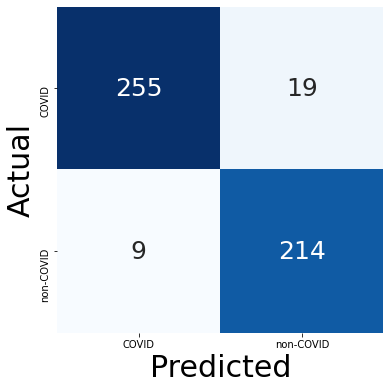

In [34]:
Y_predict_inception = inception.predict(X_test_M)
Y_predict_inception = np.argmax(Y_predict_inception, axis= 1)
Y_true = np.argmax(Y_test_M, axis=1)

cm_inception = confusion_matrix(Y_true, Y_predict_inception)
plt.figure(figsize=(6,6))

ax= sns.heatmap(cm_inception, cmap=plt.cm.Blues, annot=True,fmt='d',annot_kws={"size": 25},cbar=False, square=True, xticklabels=type_of_disease,yticklabels=type_of_disease)
ax.set_ylabel('Actual', fontsize=30)
ax.set_xlabel('Predicted', fontsize=30)
plt.savefig('Confusion matrix_inception_df.svg', format='svg', dpi=1200)

In [35]:
# convert array into dataframe
DF_I = pd.DataFrame(Y_predict_inception,columns=['Inception V3 Prediction'])

# save the dataframe as a csv file
DF_I.to_csv("inception.csv",index=False)

In [36]:
# convert array into dataframe
DF_true = pd.DataFrame(Y_true,columns=['Y True'])

# save the dataframe as a csv file
DF_true.to_csv("true_values.csv",index=False)

In [37]:
Y_train_true = np.argmax(Y_train_M, axis=1)

# convert array into dataframe
DF_true = pd.DataFrame(Y_train_true,columns=['Y True train'])

# save the dataframe as a csv file
DF_true.to_csv("train_true_values.csv",index=False)

In [38]:
metrics_inception = confusion_metrics(cm_inception)
print(metrics_inception)

True Positives: 214
True Negatives: 255
False Positives: 19
False Negatives: 9
--------------------------------------------------
Accuracy: 0.94
Mis-Classification: 0.06
Sensitivity: 0.96
Specificity: 0.93
Precision: 0.93
f1 Score: 0.94
None


Equal weightage all the three models 

In [ ]:
d_array = np.array(Y_predict_densenet)
m_array = np.array(Y_predict_mobilenet)
i_array = np.array(Y_predict_inception)

df = pd.DataFrame(d_array,m_array,i_array)#, columns = ['Densenet121 Prediction','MobilNet Prediction','Inception V3 Prediction'])

print(df)

In [ ]:
def confusion_metrics (conf_matrix):

    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    
    #accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    #mis-classification
    conf_misclassification = 1- conf_accuracy
    
    #sensitivity
    conf_sensitivity = (TP / float(TP + FN))

    #specificity
    conf_specificity = (TN / float(TN + FP))
    
    #precision
    conf_precision = (TN / float(TN + FP))

    # f1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('-'*50)

    print(f'Accuracy: {round(conf_accuracy,2)}') 
    print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')
    print(f'f1 Score: {round(conf_f1,2)}')

In [ ]:
metrics = confusion_metrics(cm)
print(metrics)

True Positives: 216
True Negatives: 262
False Positives: 12
False Negatives: 7
--------------------------------------------------
Accuracy: 0.96
Mis-Classification: 0.04
Sensitivity: 0.97
Specificity: 0.96
Precision: 0.96
f1 Score: 0.96
None


Using logistic regression for ensemble classifier

In [50]:
import pandas as pd
import numpy as np

df1 = pd.read_csv("/content/densenet training data.csv") 
df2 = pd.read_csv("/content/inception training data.csv") 
df3 = pd.read_csv("/content/mobilenet training data.csv")
df4 = pd.read_csv("/content/train_true_values.csv") 

df_train = pd.concat([df1, df2, df3, df4], axis=1)

print(df_train)



      DenseNet121 Prediction  ...  Y True train
0                          0  ...             0
1                          0  ...             0
2                          0  ...             0
3                          0  ...             0
4                          1  ...             1
...                      ...  ...           ...
1979                       0  ...             0
1980                       0  ...             0
1981                       0  ...             0
1982                       1  ...             1
1983                       1  ...             1

[1984 rows x 4 columns]


In [51]:
df11 = pd.read_csv("/content/densenet.csv") 
df21 = pd.read_csv("/content/inception.csv") 
df31 = pd.read_csv("/content/mobilenet.csv")
df41 = pd.read_csv("/content/true_values.csv") 

df_test = pd.concat([df11, df21, df31, df41], axis=1)

print(df_test)

     DenseNet121 Prediction  ...  Y True
0                         0  ...       0
1                         1  ...       1
2                         1  ...       1
3                         1  ...       1
4                         0  ...       0
..                      ...  ...     ...
492                       1  ...       0
493                       1  ...       1
494                       0  ...       0
495                       0  ...       0
496                       0  ...       0

[497 rows x 4 columns]


In [52]:
X_train = df_train.drop('Y True train',axis=1)
X_test = df_test.drop('Y True',axis=1)
y_train = df_train['Y True train']
Y_true = df_test['Y True']

In [ ]:
plt

In [53]:
from sklearn.linear_model import LogisticRegression

In [54]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [55]:
predictions = logmodel.predict(X_test)

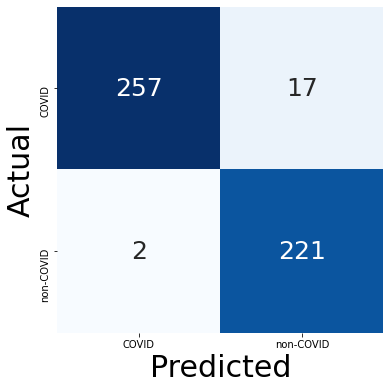

In [56]:
cm_uw = confusion_matrix(Y_true, predictions)
type_of_disease =['COVID', 'non-COVID']
plt.figure(figsize=(6,6))

ax= sns.heatmap(cm_uw, cmap=plt.cm.Blues, annot=True,fmt='d',annot_kws={"size": 25},cbar=False, square=True, xticklabels=type_of_disease,yticklabels=type_of_disease)
ax.set_ylabel('Actual', fontsize=30)
ax.set_xlabel('Predicted', fontsize=30)
plt.savefig('Confusion matrix_unequal_wts.svg', format='svg', dpi=1200)

In [57]:
#unequal weights
metrics = confusion_metrics(cm)
print(metrics)

True Positives: 221
True Negatives: 257
False Positives: 17
False Negatives: 2
--------------------------------------------------
Accuracy: 0.96
Mis-Classification: 0.04
Sensitivity: 0.99
Specificity: 0.94
Precision: 0.94
f1 Score: 0.96
None
